In [1]:
import json
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [56]:
import sentence_transformers

In [58]:
import transformers

In [59]:
transformers.__version__

'4.24.0'

In [54]:
from sentence_transformers import SentenceTransformer

In [2]:
%%capture 
!python3 -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')
model = SentenceTransformer('all-MiniLM-L6-v2')

In [19]:



with open("sentence_embedder.pkl", "wb") as f:
    pickle.dump(model, f)

In [3]:
with open('../../Downloads/mapped_skills.jsonl', 'r') as json_file:
    json_data = list(json_file)
cnt = 0    
data = []
for json_str in json_data:
    result = json.loads(json_str)
    result['id'] = cnt
    data.append(result)
    cnt+=1


In [4]:
duplication_key = []
for job in data:
    duplication_key.append([job['Company_name'],job['Job_family'],job['job_location'],job['Title'],job['Unique_key'],job['id'],job['Job_Description']])
import pandas as pd
dup_check_data = pd.DataFrame(duplication_key,columns =['Company','Family','location','Title','key','id','Job_Description'])
distinct_keys = list(dup_check_data.drop_duplicates(['Company','Family','location','Title','key'])['id'].values)


In [5]:
len(distinct_keys)

1685

In [6]:
data_unique = [w for w in data if w['id'] in distinct_keys]

In [25]:
pd.DataFrame(distinct_keys).to_csv("unique_jds.csv")

In [7]:
len(data_unique)

1685

In [26]:



data = pd.DataFrame(data_unique)[['id','Job_family', 'new_skill_map','Company_name']]

skills = []
for jd_skills in data['new_skill_map']:
    skilll_list = list(jd_skills.keys())
#     skilll_list.sort()
    skills.append(', '.join(skilll_list))
    
data['skills'] = skills

data_embeddings = []

for des in tqdm(list(data['skills'])):
    embeddings = model.encode(des,)
    data_embeddings.append(embeddings)
    
data['embeddings'] = data_embeddings

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1685/1685 [00:21<00:00, 79.06it/s]


In [9]:
data.groupby(['Job_family']).count()

,id,new_skill_map,Company_name,skills,embeddings
Job_family,,,,,
Business Analyst,363,363,363,363,363
Data Engineer,408,408,408,408,408
Data Scientist,307,307,307,307,307
Hardware Engineer,67,67,67,67,67
Machine Learning Engineer,42,42,42,42,42
Product Manager,412,412,412,412,412
Software Development Engineer,86,86,86,86,86


In [10]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [43]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 50)
  
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(data_embeddings)
    kmeanModel.fit(data_embeddings)
  
    distortions.append(sum(np.min(cdist(data_embeddings, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / len(data_embeddings))
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(data_embeddings, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / len(data_embeddings)
    mapping2[k] = kmeanModel.inertia_

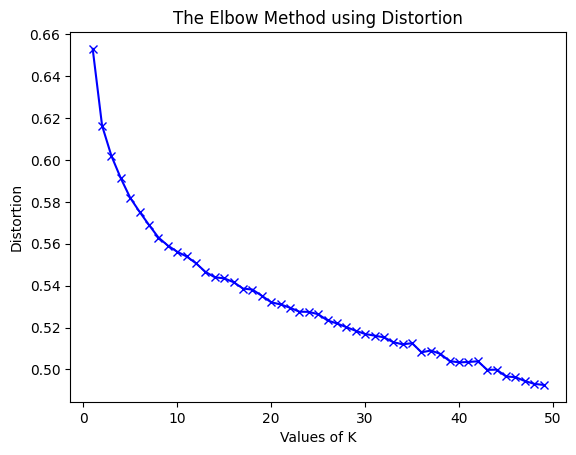

In [44]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [44]:
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(data_embeddings)

KMeans(n_clusters=10)

In [45]:
clustering_model

KMeans(n_clusters=10)

In [46]:
cluster_assignment = clustering_model.labels_
data['cluster'] = cluster_assignment

In [50]:

with open("data_for_recommendation.pkl", "wb") as f:
    pickle.dump(data, f)

In [16]:
import pickle

In [53]:

with open("clustering_model_10.pkl", "wb") as f:
    pickle.dump(clustering_model, f)

In [31]:
data

,id,Job_family,new_skill_map,Company_name,skills,embeddings,cluster
0,0,Business Analyst,"{'ADP': 1, 'Implementation': 1, 'Project Manag...",ADP,"ADP, Implementation, Project Management, Proje...","[-0.039233074, 0.0064511355, 0.01725676, 0.004...",7
1,1,Data Scientist,"{'ADP': 8, 'Spark': 1, 'Hive': 1, 'Applied Mat...",ADP,"ADP, Spark, Hive, Applied Mathematics, Busines...","[-0.01583977, -0.09448071, -0.04065954, -0.004...",2
2,2,Data Scientist,"{'ADP': 7, 'Python': 2, 'Spark': 1, 'Hive': 1,...",ADP,"ADP, Python, Spark, Hive, Data Mining, Machine...","[-0.0076891477, -0.08809161, 0.019311106, 0.01...",9
3,3,Data Scientist,"{'ADP': 5, 'Data Science': 2, 'Solve Problems'...",ADP,"ADP, Data Science, Solve Problems, Dataflow, K...","[-0.0043481714, -0.0672009, -0.008916268, -0.0...",10
4,4,Data Scientist,"{'ADP': 7, 'Analytics': 2, 'Python': 2, 'Table...",ADP,"ADP, Analytics, Python, Tableau, Machine Learn...","[-0.009007034, -0.06993201, -0.014506957, 0.03...",2
...,...,...,...,...,...,...,...
1680,3432,Business Analyst,"{'Materials Management': 1, 'MAM': 1, 'Vendor ...",Zoox,"Materials Management, MAM, Vendor Resources, R...","[0.016408702, -0.06765434, -0.016455805, 0.006...",4
1681,3433,Data Engineer,"{'Spark': 1, 'Data Warehousing': 1, 'Building ...",Zoox,"Spark, Data Warehousing, Building Models, Kine...","[-0.021460515, -0.08527697, -0.014976204, -0.0...",2
1682,3434,Data Engineer,"{'Spark': 1, 'PostgreSQL': 1, 'Data Warehousin...",Zoox,"Spark, PostgreSQL, Data Warehousing, Building ...","[-0.042030577, -0.07744181, -0.013516542, -0.0...",2
1683,3435,Data Engineer,"{'Python': 1, 'Data Collection': 1, 'Agile': 1...",Zoox,"Python, Data Collection, Agile, Data Processin...","[-0.031140018, -0.055820808, 0.002453158, -0.0...",9


In [56]:
data.to_csv('./job_cluster_maping_using_Skills_embedding_unique.csv', encoding='utf-8', index=False)

In [36]:
data.head()

,id,Job_family,new_skill_map,Company_name,skills,embeddings,cluster
0,0,Business Analyst,"{'ADP': 1, 'Implementation': 1, 'Project Manag...",ADP,"ADP, Implementation, Project Management, Proje...","[-0.039233074, 0.0064511355, 0.01725676, 0.004...",7
1,1,Data Scientist,"{'ADP': 8, 'Spark': 1, 'Hive': 1, 'Applied Mat...",ADP,"ADP, Spark, Hive, Applied Mathematics, Busines...","[-0.01583977, -0.09448071, -0.04065954, -0.004...",2
2,2,Data Scientist,"{'ADP': 7, 'Python': 2, 'Spark': 1, 'Hive': 1,...",ADP,"ADP, Python, Spark, Hive, Data Mining, Machine...","[-0.0076891477, -0.08809161, 0.019311106, 0.01...",9
3,3,Data Scientist,"{'ADP': 5, 'Data Science': 2, 'Solve Problems'...",ADP,"ADP, Data Science, Solve Problems, Dataflow, K...","[-0.0043481714, -0.0672009, -0.008916268, -0.0...",10
4,4,Data Scientist,"{'ADP': 7, 'Analytics': 2, 'Python': 2, 'Table...",ADP,"ADP, Analytics, Python, Tableau, Machine Learn...","[-0.009007034, -0.06993201, -0.014506957, 0.03...",2


In [47]:
new_data = data.groupby(['Job_family','cluster']).count().reset_index()

In [48]:
pd.pivot_table(new_data, values='new_skill_map', index=['Job_family'],
                    columns=['cluster'], aggfunc=np.sum,fill_value=0)

cluster,0,1,2,3,4,5,6,7,8,9
Job_family,,,,,,,,,,
Business Analyst,16,20,12,90,46,0,60,56,63,0
Data Engineer,39,111,12,3,41,129,9,1,3,60
Data Scientist,8,31,7,9,109,51,4,3,1,84
Hardware Engineer,8,0,44,0,1,0,9,4,1,0
Machine Learning Engineer,3,0,0,0,0,6,1,0,0,32
Product Manager,42,19,28,30,16,5,64,86,118,4
Software Development Engineer,47,7,14,4,0,3,2,1,6,2


In [24]:
new_data.to_csv('results_jf_skills.csv', encoding='utf-8', index=False)

In [52]:

with open("clustering_model_10.pkl", "rb") as f2:
    clustering_model = pickle.load(f2)

EOFError: Ran out of input

In [10]:
import pickle


In [57]:

with open("kmeans_12_clusters.pkl", "wb") as f:
    pickle.dump(clustering_model, f)

In [11]:
with open("kmeans_12_clusters.pkl", "rb") as f:
    model_k = pickle.load(f)

In [12]:
cluster_assignment = model_k.labels_
data['cluster'] = cluster_assignment

In [50]:
new_data = data.groupby(['Job_family','cluster']).count().reset_index()

In [51]:
pd.pivot_table(new_data, values='new_skill_map', index=['Job_family'],
                    columns=['cluster'], aggfunc=np.sum,fill_value=0)

cluster,0,1,2,3,4,5,6,7,8
Job_family,,,,,,,,,
Business Analyst,38,0,51,211,24,0,116,64,178
Data Engineer,4,332,196,6,40,92,5,114,21
Data Scientist,1,79,69,29,29,173,2,234,12
Hardware Engineer,5,0,0,26,104,5,1,21,0
Machine Learning Engineer,0,6,0,1,3,56,0,0,0
Product Manager,99,17,51,281,63,33,290,27,71
Software Development Engineer,0,23,29,4,56,2,41,0,2


KMeans(n_clusters=9)

In [36]:
myskills =['Spark','Jira',
 'GCP',
 'Web Applications',
 'GitHub',
 'Troubleshoot Issues',
 'Forecasting',
 'MySQL',
 'Project Planning',
 'Docker',
 'MS Word',
 'Resolving Issues',
 'Javascript',
 'Linux',
 'Amazon Web Services',
 'Flask',
 'Information Technology',
 'Jenkins',
 'Web App Architecture',
 'Angular',
 'Splunk',
 'GIT',
 'C',
 'Java',
 'HTML',
 'Excel',
 'Database Management',
 'Python',
 'Powerpoint',
 'Amazon EC2',
 'Windows',
 'MAC',
 'Computer Engineering',
 'Software Engineering Skills',
 'Computer Science',
 'CSS']

In [37]:
myskill_embedding = model.encode(', '.join(myskills))

In [26]:
from scipy import spatial

def cosine(x):
    global myskill_embedding
    return 1 - spatial.distance.cosine(x,myskill_embedding)

In [27]:
from sklearn.metrics import jaccard_score

In [28]:

def jaccard(x):
    global myskills
    x2 = list(x.keys())
    x_set = set(x2)
    y_set = set(myskills)
    denom = x_set.union(y_set)
    num = x_set.intersection(y_set)
    return len(num)/len(denom)

In [38]:
data['similarity_jaccard'] = data["new_skill_map"].apply(jaccard)

In [34]:
data['similarity'] = data["embeddings"].apply(cosine)

In [39]:
###Aditya
data.sort_values(['similarity'],ascending=False).head(30)

,id,Job_family,new_skill_map,Company_name,skills,embeddings,cluster,similarity_jaccard,similarity
484,988,Data Engineer,"{'Amazon EC2': 2, 'Python': 2, 'Scala': 2, 'Am...",Comcast,"Amazon EC2, Python, Scala, Amazon Web Services...","[-0.029952303, -0.07571909, -0.021984985, -0.0...",5,0.113924,0.812343
173,378,Software Development Engineer,"{'MS Office': 1, 'Documentation': 1, 'Computer...",American Express,"MS Office, Documentation, Computer Engineering...","[0.015359882, -0.08632852, 0.014692792, 0.0136...",3,0.185185,0.784471
314,616,Data Engineer,"{'Maintainable': 2, 'HBase': 1, 'Collaboration...",Boeing,"Maintainable, HBase, Collaboration, Confluence...","[0.041911274, -0.08024584, -0.005645029, -0.00...",3,0.109375,0.774707
1364,2724,Data Engineer,"{'Spark': 2, 'Discover Insights': 1, 'Amazon W...",Samsung,"Spark, Discover Insights, Amazon Web Services ...","[0.016578516, -0.086782664, -0.021818753, 0.00...",5,0.088235,0.774477
944,1915,Data Engineer,"{'Spark': 1, 'Hive': 1, 'Computer Engineering'...",Micron,"Spark, Hive, Computer Engineering, System Test...","[0.0062808474, -0.09137507, 0.0074214665, 0.01...",5,0.127273,0.769660
739,1495,Software Development Engineer,"{'GIT': 2, 'Computer Science': 2, 'Mathematics...",Intel,"GIT, Computer Science, Mathematics, Object Ori...","[0.039532423, -0.07307249, -0.0253444, 0.01015...",3,0.105263,0.769098
740,1496,Software Development Engineer,"{'GIT': 2, 'Computer Science': 2, 'Mathematics...",Intel,"GIT, Computer Science, Mathematics, Object Ori...","[0.039532423, -0.07307249, -0.0253444, 0.01015...",3,0.105263,0.769098
1104,2208,Data Scientist,"{'Tableau': 5, 'Java': 3, 'Legally Live': 2, '...",Northrop Grumman,"Tableau, Java, Legally Live, Agile, SQL Querie...","[0.02330126, -0.083913065, -0.02591441, 0.0024...",5,0.081967,0.767739
979,2008,Data Engineer,"{'Apache Griffin': 1, 'HBase': 1, 'Data Engine...",Morgan Stanley,"Apache Griffin, HBase, Data Engineering, Troub...","[0.0007311801, -0.035987064, -0.0215941, -0.02...",5,0.017241,0.763574
742,1498,Software Development Engineer,"{'GIT': 2, 'Computer Science': 2, 'Mathematics...",Intel,"GIT, Computer Science, Mathematics, Object Ori...","[0.0418282, -0.07147359, -0.025781339, 0.01115...",3,0.105263,0.763275


In [150]:
## Satwant
data.sort_values(['similarity'],ascending=False).head(30)

,id,Job_family,new_skill_map,Company_name,skills,embeddings,cluster,similarity,similarity_jaccard
484,988,Data Engineer,"{'Amazon EC2': 2, 'Python': 2, 'Scala': 2, 'Am...",Comcast,"Amazon EC2, Python, Scala, Amazon Web Services...","[-0.029952303, -0.07571909, -0.021984985, -0.0...",5,0.787741,0.097222
1240,2465,Data Engineer,"{'Programming': 2, 'Designing': 2, 'Spark': 1,...",Progressive,"Programming, Designing, Spark, Amazon Web Serv...","[0.02437532, -0.08661847, -0.046783242, 0.0004...",5,0.772672,0.095238
741,1497,Software Development Engineer,"{'Javascript': 3, 'Software Development Method...",Intel,"Javascript, Software Development Methodologies...","[0.011517448, -0.10894976, -0.017969849, 0.012...",3,0.761292,0.163265
1064,2138,Software Development Engineer,"{'Python': 2, 'Build Tools': 1, 'Json': 1, 'Co...",Nextera Energy,"Python, Build Tools, Json, Code Reviews, Javas...","[-0.059889376, -0.066355474, -0.046218082, -0....",3,0.755965,0.116279
594,1136,Data Engineer,"{'Business Management': 2, 'Mongodb': 2, 'Docu...",Goldman Sachs,"Business Management, Mongodb, Documentation, J...","[0.055408258, -0.052068796, -0.00396572, 0.046...",3,0.755160,0.085106
597,1139,Data Engineer,"{'Business Management': 2, 'Mongodb': 2, 'Docu...",Goldman Sachs,"Business Management, Mongodb, Documentation, J...","[0.055408258, -0.052068796, -0.00396572, 0.046...",3,0.755160,0.085106
740,1496,Software Development Engineer,"{'GIT': 2, 'Computer Science': 2, 'Mathematics...",Intel,"GIT, Computer Science, Mathematics, Object Ori...","[0.039532423, -0.07307249, -0.0253444, 0.01015...",3,0.751521,0.200000
739,1495,Software Development Engineer,"{'GIT': 2, 'Computer Science': 2, 'Mathematics...",Intel,"GIT, Computer Science, Mathematics, Object Ori...","[0.039532423, -0.07307249, -0.0253444, 0.01015...",3,0.751521,0.200000
1492,2990,Software Development Engineer,"{'Data Analytics': 1, 'React.js': 1, 'Web Tech...",Tesla,"Data Analytics, React.js, Web Technologies, Ra...","[0.03333203, -0.08701851, -0.017025959, 0.0069...",3,0.750567,0.085106
1065,2139,Software Development Engineer,"{'Container Strategies': 2, 'React.js': 1, 'Ja...",Nextera Energy,"Container Strategies, React.js, Javascript, Bi...","[0.010384694, -0.009041532, 0.037015427, 0.010...",3,0.743741,0.177778
